In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import math
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder

In [214]:
train = pd.read_csv('titanic.train.csv')
test = pd.read_csv('titanic.test.csv')

In [215]:
print(train.columns)
train.iloc[0]

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')


pclass                                 3
survived                               1
name         Sheerlinck, Mr. Jan Baptist
sex                                 male
age                                 29.0
sibsp                                  0
parch                                  0
ticket                            345779
fare                                 9.5
cabin                                NaN
embarked                               S
boat                                  11
body                                 NaN
home.dest                            NaN
Name: 0, dtype: object

In [216]:
print(len(train['ticket'].unique()))
print(len(train['fare'].unique()))
print(len(train['cabin'].unique()))

697
253
143


In [217]:
def clean_preprocess(train, test):
    '''
    Cleans and Preprocesses the inputted data to prepare it to be used for predictions in a model

    Args:
      data (pd.DataFrame): Dataframe containing titanic data
    
    Return:
      X (pd.DataFrame): DataFrame containing cleaned input data for a model
      y (pd.Series): Series containing target variables for a model
    '''
    columns = ['pclass', 'fare', 'sex', 'parch', 'sibsp', 'cabin']

    
    data = pd.concat([train, test])
    # data = data.dropna(subset=columns)
    
    X = data[columns]
    
    one_hot_sex = pd.get_dummies(X['sex'])
    X = X.drop('sex', axis=1)
    X = pd.concat([X, one_hot_sex], axis=1)

    one_hot_cabin = pd.get_dummies(X['cabin'])
    X = X.drop('cabin', axis=1)
    X = pd.concat([X, one_hot_cabin], axis=1)
    
    y = data['survived']

    print(len(X))
    print(len(y))
    clean_X = X[~X.isna().any(axis=1)]
    y = y[~X.isna().any(axis=1)]

    print(len(clean_X))
    print(len(y))
    
    X = clean_X.to_numpy().astype('float64')
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X[:len(train)], y[:len(train)], X[len(train):], y[len(train):]

In [218]:
train_X, train_y, test_X, test_y = clean_preprocess(train, test)

1309
1309
1308
1308


In [219]:
class LogisticRegression():

    def __init__(self, lr=.0001):
        self.lr = lr

    def fit(self, X, y, iterations=100):
        costs = []

        self.weights = np.random.randn(len(X[0]))
        self.bias = np.random.randn()
        
        for _ in range(iterations):
            scores = self.score(X)

            self.weights -= self.lr * self.gradW(X, y, scores)
            self.bias -= self.lr * self.gradB(y, scores)

            costs.append(self.cost(y, scores))

        return costs

    def predict(self, X):
        scores = self.score(X)

        return [1 if score >= .5 else 0 for score in scores]

    def evaluate(self, predictions, y):
        tp, tn, fp, fn = (0, 0, 0, 0)
        
        for prediction, actual in zip(predictions, y):
            if actual == prediction:
                if prediction == 1:
                    tp += 1
                else:
                    tn += 1
            else:
                if prediction == 1:
                    fp += 1
                else:
                    fn += 1

        acc = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        fscore = (2 * precision * recall) / (precision + recall)

        return acc, precision, recall, fscore
 
    def score(self, X):
        return self.sigmoid((self.weights @ X.T).T + self.bias)

    def cost(self, y, scores):
        cost = -np.sum(y * np.log(scores) + (1 - y) * np.log(1 - scores))
        
        return -np.sum(y * np.log(scores) + (1 - y) * np.log(1 - scores + 1e-9))

    def gradW(self, X, y, scores):
        return (np.expand_dims(scores - y, 0) @ X).sum(axis=0)

    def gradB(self, y, scores):
        return (scores - y).sum(axis=0)

    def gradSigmoid(self, X):
        return self.sigmoid(X) * (1 - self.sigmoid(X))

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

In [220]:
log_regression = LogisticRegression(lr=.001)

costs = log_regression.fit(train_X, train_y, 100)

/tmp/ipykernel_218308/2359982507.py:53: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(y * np.log(scores) + (1 - y) * np.log(1 - scores))
/tmp/ipykernel_218308/2359982507.py:53: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(y * np.log(scores) + (1 - y) * np.log(1 - scores))
/tmp/ipykernel_218308/2359982507.py:53: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(y * np.log(scores) + (1 - y) * np.log(1 - scores))
/tmp/ipykernel_218308/2359982507.py:53: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(y * np.log(scores) + (1 - y) * np.log(1 - scores))
/tmp/ipykernel_218308/2359982507.py:53: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(y * np.log(scores) + (1 - y) * np.log(1 - scores))
/tmp/ipykernel_218308/2359982507.py:53: RuntimeWarning: divide by zero encountered in log
  cost = -np.sum(y * np.log(scores) + (1 - y) * np.log(1 - scores))
/tmp/ipykernel_218308/2359982507.py:53: RuntimeWarni

Text(0.5, 1.0, 'Training Loss')

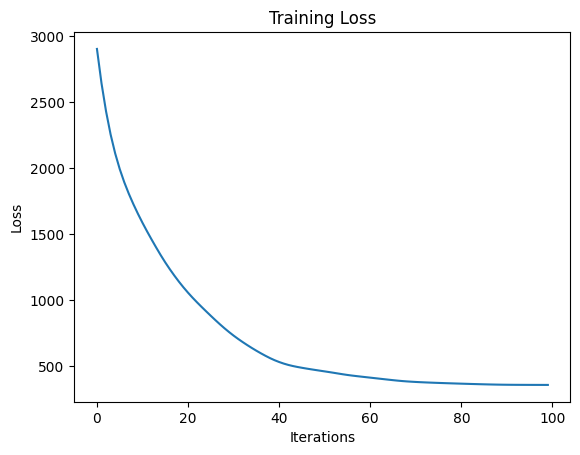

In [221]:
plt.plot(range(len(costs)), costs)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')

In [222]:
train_results = log_regression.evaluate(log_regression.predict(train_X), train_y)
test_results = log_regression.evaluate(log_regression.predict(test_X), test_y)

print(f'Train Accuracy: {train_results[0]:.4f}')
print(f'Test Accuracy: {test_results[0]:.4f}')

Train Accuracy: 0.8282828282828283
Test Accuracy: 0.7553956834532374


## Features Used
The features I used to train my logistic regression model were 'pclass', 'fare', 'sex', 'parch', 'sibsp', 'cabin'. The 'cabin' and 'sex' variables are categorical, so I used one-hot encoding to capture the variables numerically.

## Preprocessing
To transform the data I one-hot encoded the categorical data. I then applied the Standard Scaler to all of the data so that all of our features are normalized and the scaling of the features does not impact the scale of our weights. 

## Learning Rate
I used a learning rate of .001 as I found it operated the best in my testing by striking a balance between changing the weights every iteration and not ping-pong on either side of the local minima.


In [223]:
model = keras.Sequential(
    [
        keras.Input(shape=len(train_X[0])),
        layers.Dense(8, activation="relu"),
        layers.Dense(4, activation='relu'),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8)                 1544      
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 1585 (6.19 KB)
Trainable params: 1585 (6.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [224]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_X, train_y, batch_size=256, epochs=100, validation_split=0.1)

Epoch 1/100
4/4 [==============================] - 0s 26ms/step - loss: 0.8527 - accuracy: 0.3920 - val_loss: 0.8919 - val_accuracy: 0.3778
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.8228 - accuracy: 0.4245 - val_loss: 0.8805 - val_accuracy: 0.5556
Epoch 3/100
4/4 [==============================] - 0s 7ms/step - loss: 0.8009 - accuracy: 0.6779 - val_loss: 0.8735 - val_accuracy: 0.6111
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 0.7821 - accuracy: 0.7179 - val_loss: 0.8668 - val_accuracy: 0.6333
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.7658 - accuracy: 0.7241 - val_loss: 0.8598 - val_accuracy: 0.6778
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.7510 - accuracy: 0.7303 - val_loss: 0.8525 - val_accuracy: 0.6778
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.7362 - accuracy: 0.7316 - val_loss: 0.8449 - val_accuracy: 0.6889
Epoch 8/100
4/4 [=========

In [236]:
scores = model.evaluate(test_X, test_y)
print(f'Accuracy of NN model: {scores[1]:.4f}')

14/14 [==============================] - 0s 844us/step - loss: 0.7500 - accuracy: 0.7482
Accuracy of NN model: 0.7482


# Model Architecure Graph
!['Model Architechure Graph'](model_graph.png)